In [19]:
!unzip /content/drive/MyDrive/brain-tumor-2D.zip

Archive:  /content/drive/MyDrive/brain-tumor-2D.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/

In [20]:

import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt

# Gaussian Bernoulli

In [27]:
#from RBM import RBM
import torch

class GaussianBernoulliRBM(RBM):

    '''
    Visisble layer can assume real values
    Hidden layer assumes Binarry Values only
    '''

    def to_visible(self,X):
        '''
        the visible units follow gaussian distributions here
        :params X: torch tensor shape = (n_samples , n_features)
        :returns X_prob - the new reconstructed layers(probabilities)
                sample_X_prob - sample of new layer(Gibbs Sampling)
        '''

        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)

        sample_X_prob = X_prob + torch.randn(X_prob.shape)

        return X_prob,sample_X_prob

# DBN

In [24]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
#from RBM import RBM




class DBN(nn.Module):
    def __init__(self,
                visible_units = 256,
                hidden_units = [64 , 100],
                k = 2,
                learning_rate = 1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        super(DBN,self).__init__()

        self.n_layers = len(hidden_units)
        self.rbm_layers =[]
        self.rbm_nodes = []

        # Creating different RBM layers
        for i in range(self.n_layers ):
            input_size = 0
            if i==0:
                input_size = visible_units
            else:
                input_size = hidden_units[i-1]
            rbm = RBM(visible_units = input_size,
                    hidden_units = hidden_units[i],
                    k= k,
                    learning_rate = learning_rate,
                    learning_rate_decay = learning_rate_decay,
                    xavier_init = xavier_init,
                    increase_to_cd_k = increase_to_cd_k,
                    use_gpu=use_gpu)

            self.rbm_layers.append(rbm)

        # rbm_layers = [RBM(rbn_nodes[i-1] , rbm_nodes[i],use_gpu=use_cuda) for i in range(1,len(rbm_nodes))]
        self.W_rec = [nn.Parameter(self.rbm_layers[i].W.data.clone()) for i in range(self.n_layers-1)]
        self.W_gen = [nn.Parameter(self.rbm_layers[i].W.data) for i in range(self.n_layers-1)]
        self.bias_rec = [nn.Parameter(self.rbm_layers[i].h_bias.data.clone()) for i in range(self.n_layers-1)]
        self.bias_gen = [nn.Parameter(self.rbm_layers[i].v_bias.data) for i in range(self.n_layers-1)]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)

        for i in range(self.n_layers-1):
            self.register_parameter('W_rec%i'%i, self.W_rec[i])
            self.register_parameter('W_gen%i'%i, self.W_gen[i])
            self.register_parameter('bias_rec%i'%i, self.bias_rec[i])
            self.register_parameter('bias_gen%i'%i, self.bias_gen[i])


    def forward(self , input_data):
        '''
            running the forward pass
            do not confuse with training this just runs a foward pass
        '''
        v = input_data
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v,v = self.rbm_layers[i].to_hidden(v)
        return p_v,v

    def reconstruct(self,input_data):
        '''
        go till the final layer and then reconstruct
        '''
        h = input_data
        p_h = 0
        for i in range(len(self.rbm_layers)):
            h = h.view((h.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_h,h = self.rbm_layers[i].to_hidden(h)

        v = h
        for i in range(len(self.rbm_layers)-1,-1,-1):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)
            p_v,v = self.rbm_layers[i].to_visible(v)
        return p_v,v



    def train_static(self, train_data,train_labels,num_epochs=50,batch_size=10):
        '''
        Greedy Layer By Layer training
        Keeping previous layers as static
        '''

        tmp = train_data

        for i in range(len(self.rbm_layers)):
            print("-"*20)
            print("Training the {} st rbm layer".format(i+1))

            tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
            tensor_y = train_labels.type(torch.FloatTensor)
            _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
            _dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader

            self.rbm_layers[i].train(_dataloader , num_epochs,batch_size)
            # print(train_data.shape)
            v = tmp.view((tmp.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v , v = self.rbm_layers[i].forward(v)
            tmp = v
            # print(v.shape)
        return

    def train_ith(self, train_data,train_labels,num_epochs,batch_size,ith_layer):
        '''
        taking ith layer at once
        can be used for fine tuning
        '''
        if(ith_layer-1>len(self.rbm_layers) or ith_layer<=0):
            print("Layer index out of range")
            return
        ith_layer = ith_layer-1
        v = train_data.view((train_data.shape[0] , -1)).type(torch.FloatTensor)

        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].forward(v)

        tmp = v
        tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
        tensor_y = train_labels.type(torch.FloatTensor)
        _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
        _dataloader = torch.utils.data.DataLoader(_dataset , batch_size=batch_size,drop_last=True)
        self.rbm_layers[ith_layer].train(_dataloader, num_epochs,batch_size)
        return

The number shown is the number: 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


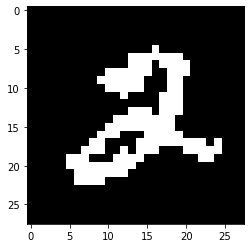

In [32]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np

mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

# I have have set these hyper parameters although you can experiment with them to find better hyperparameters.
dbn_mnist = DBN(visible_units=28*28 ,
                hidden_units=[23*23 ,18*18] ,
                k = 5,
                learning_rate = 0.01,
                learning_rate_decay = True,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False)
num_epochs = 1
batch_size = 10



--------------------
Training the 1 st rbm layer

RBM fitting: 0it [00:00, ?it/s]
RBM fitting: 13it [00:00, 123.29it/s]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")



RBM fitting: 26it [00:00, 123.01it/s]
RBM fitting: 39it [00:00, 124.72it/s]
RBM fitting: 52it [00:00, 125.77it/s]
RBM fitting: 65it [00:00, 126.11it/s]
RBM fitting: 78it [00:00, 125.79it/s]
RBM fitting: 92it [00:00, 127.11it/s]
RBM fitting: 104it [00:00, 122.10it/s]
RBM fitting: 117it [00:00, 122.41it/s]
RBM fitting: 130it [00:01, 123.61it/s]
RBM fitting: 144it [00:01, 126.28it/s]
RBM fitting: 157it [00:01, 127.31it/s]
RBM fitting: 2617it [00:40, 132.68it/s]
RBM fitting: 183it [00:01, 126.20it/s]
RBM fitting: 196it [00:01, 126.89it/s]
RBM fitting: 209it [00:01, 127.00it/s]
RBM fitting: 222it [00:01, 124.20it/s]
RBM fitting: 235it [00:01, 125.08it/s]
RBM fitting: 248it [00:01, 125.25it/s]
RBM fitting: 261it [00:02, 124.45it/s]
RBM fitting: 274it [00:02, 123.82it/s]
RBM fitting: 287it [00:02, 125.26it/s]
RBM fitting: 300it [00:02, 124.80it/s]
RBM fitting: 313it [00:02, 125.69it/s]
RBM fitting: 326it [00:02, 125.87it/s]
RBM fitting: 340it [00:02, 127.44it/s]
RBM fitting: 353it [00:02, 12

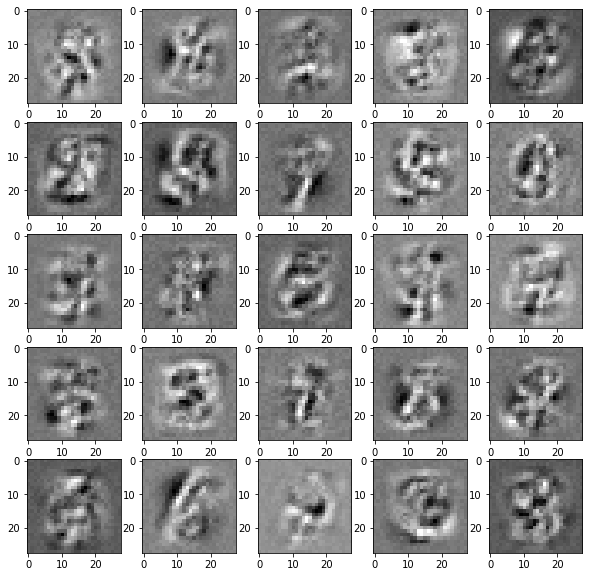

In [34]:

dbn_mnist.train_static(mnist_data.train_data,mnist_data.targets,num_epochs , batch_size)

# visualising layer 1
learned_weights = dbn_mnist.rbm_layers[0].W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

# RBM

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import sys

BATCH_SIZE = 64

class RBM(nn.Module):
    '''
    This class defines all the functions needed for an BinaryRBN model
    where the visible and hidden units are both considered binary
    '''

    def __init__(self,
                visible_units=256,
                hidden_units = 64,
                k=2,
                learning_rate=1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        '''
        Defines the model
        W:Wheights shape (visible_units,hidden_units)
        c:hidden unit bias shape (hidden_units , )
        b : visible unit bias shape(visisble_units ,)
        '''
        super(RBM,self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16


        # Initialization
        if not self.xavier_init:
            self.W = torch.randn(self.visible_units,self.hidden_units) * 0.01 #weights
        else:
            self.xavier_value = torch.sqrt(torch.FloatTensor([1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units) #hidden layer bias
        self.v_bias = torch.zeros(self.visible_units) #visible layer bias


    def to_hidden(self ,X):
        '''
        Converts the data in visible layer to hidden layer
        also does sampling
        X here is the visible probabilities
        :param X: torch tensor shape = (n_samples , n_features)
        :return -  X_prob - new hidden layer (probabilities)
                    sample_X_prob - Gibbs sampling of hidden (1 or 0) based
                                on the value
        '''
        X_prob = torch.matmul(X,self.W)
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        X_prob  = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def to_visible(self,X):
        '''
        reconstructs data from hidden layer
        also does sampling
        X here is the probabilities in the hidden layer
        :returns - X_prob - the new reconstructed layers(probabilities)
                    sample_X_prob - sample of new layer(Gibbs Sampling)
        '''
        # computing hidden activations and then converting into probabilities
        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def sampling(self,prob):
        '''
        Bernoulli sampling done based on probabilities s
        '''
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self , data):
        '''
        Computes the reconstruction error for the data
        handled by pytorch by loss functions
        '''
        return self.contrastive_divergence(data, False)

    def reconstruct(self , X,n_gibbs):
        '''
        This will reconstruct the sample with k steps of gibbs Sampling
        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.to_hidden(v)
            prob_v_,v = self.to_visible(prob_h_)
        return prob_v_,v


    def contrastive_divergence(self, input_data ,training = True,
                                n_gibbs_sampling_steps=1,lr = 0.001):
        # positive phase

        positive_hidden_probabilities,positive_hidden_act  = self.to_hidden(input_data)

        # calculating W via positive side
        positive_associations = torch.matmul(input_data.t() , positive_hidden_act)



        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities , _ = self.to_visible(hidden_activations)
            hidden_probabilities,hidden_activations = self.to_hidden(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = torch.matmul(negative_visible_probabilities.t() , negative_hidden_probabilities)


        # Update parameters
        if(training):

            batch_size = self.batch_size

            g = (positive_associations - negative_associations)
            grad_update = g / batch_size
            v_bias_update = torch.sum(input_data - negative_visible_probabilities,dim=0)/batch_size
            h_bias_update = torch.sum(positive_hidden_probabilities - negative_hidden_probabilities,dim=0)/batch_size

            self.W += lr * grad_update
            self.v_bias += lr * v_bias_update
            self.h_bias += lr * h_bias_update


        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , dim = 0))

        return error,torch.sum(torch.abs(grad_update))


    def forward(self,input_data):
        'data->hidden'
        return  self.to_hidden(input_data)
    def step(self,input_data,epoch,num_epochs):
        '''
            Includes the foward prop plus the gradient descent
            Use this for training
        '''
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch/num_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate

        return self.contrastive_divergence(input_data , True,n_gibbs_sampling_steps,lr);


    def train(self,train_dataloader , num_epochs = 50,batch_size=16):

        self.batch_size = batch_size
        if(isinstance(train_dataloader ,torch.utils.data.DataLoader)):
            train_loader = train_dataloader
        else:
            train_loader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)


        for epoch in range(1 , num_epochs+1):
            epoch_err = 0.0
            n_batches = int(len(train_loader))
            # print(n_batches)

            cost_ = torch.FloatTensor(n_batches , 1)
            grad_ = torch.FloatTensor(n_batches , 1)

            for i,(batch,_) in tqdm(enumerate(train_loader),ascii=True,
                                desc="RBM fitting", file=sys.stdout):

                batch = batch.view(len(batch) , self.visible_units)
                
                if(self.use_gpu):
                    batch = batch.cuda()
                cost_[i-1],grad_[i-1] = self.step(batch,epoch,num_epochs)


            print("Epoch:{} ,avg_cost = {} ,std_cost = {} ,avg_grad = {} ,std_grad = {}".format(epoch,\
                                                            torch.mean(cost_),\
                                                            torch.std(cost_),\
                                                            torch.mean(grad_),\
                                                            torch.std(grad_)))

        return

# RBM on dataset

In [36]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np

In [37]:
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(

                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

In [39]:
# Need to convert th data into binary variables
mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()

The number shown is the number: 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


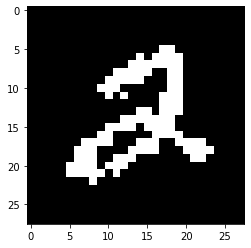

In [40]:
#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [42]:
# If we train on the whole set we expect it to learn to detect edges.
batch_size= 10
tensor_x = mnist_data.data.type(torch.FloatTensor) # transform to torch tensors
tensor_y = mnist_data.targets.type(torch.FloatTensor)
_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
train_loader = torch.utils.data.DataLoader(_dataset,
                    batch_size=batch_size, shuffle=True,drop_last = True)

In [43]:
# I have have set these hyper parameters although you can experiment with them to find better hyperparameters.
visible_units=28*28
hidden_units = 500
k=3
learning_rate=0.01
learning_rate_decay = True
xavier_init = True
increase_to_cd_k = False
use_gpu = False


rbm_mnist = RBM(visible_units,hidden_units,k ,learning_rate,learning_rate_decay,xavier_init,
                increase_to_cd_k,use_gpu)

In [44]:
epochs = 30

rbm_mnist.train(train_loader , epochs,batch_size)

Streaming output truncated to the last 5000 lines.
RBM fitting: 4517it [00:30, 151.11it/s]
RBM fitting: 4533it [00:30, 152.41it/s]
RBM fitting: 4549it [00:30, 147.61it/s]
RBM fitting: 4564it [00:30, 148.17it/s]
RBM fitting: 4580it [00:30, 150.15it/s]
RBM fitting: 4596it [00:30, 152.30it/s]
RBM fitting: 4612it [00:30, 153.94it/s]
RBM fitting: 4628it [00:31, 149.19it/s]
RBM fitting: 4643it [00:31, 149.14it/s]
RBM fitting: 4659it [00:31, 152.13it/s]
RBM fitting: 4675it [00:31, 154.10it/s]
RBM fitting: 4691it [00:31, 155.26it/s]
RBM fitting: 4707it [00:31, 150.15it/s]
RBM fitting: 4723it [00:31, 152.16it/s]
RBM fitting: 4739it [00:31, 151.47it/s]
RBM fitting: 4755it [00:31, 152.76it/s]
RBM fitting: 4771it [00:32, 154.25it/s]
RBM fitting: 4787it [00:32, 146.71it/s]
RBM fitting: 4803it [00:32, 149.15it/s]
RBM fitting: 4819it [00:32, 150.84it/s]
RBM fitting: 4835it [00:32, 151.86it/s]
RBM fitting: 4851it [00:32, 151.69it/s]
RBM fitting: 4867it [00:32, 146.51it/s]
RBM fitting: 4883it [00:32, 1

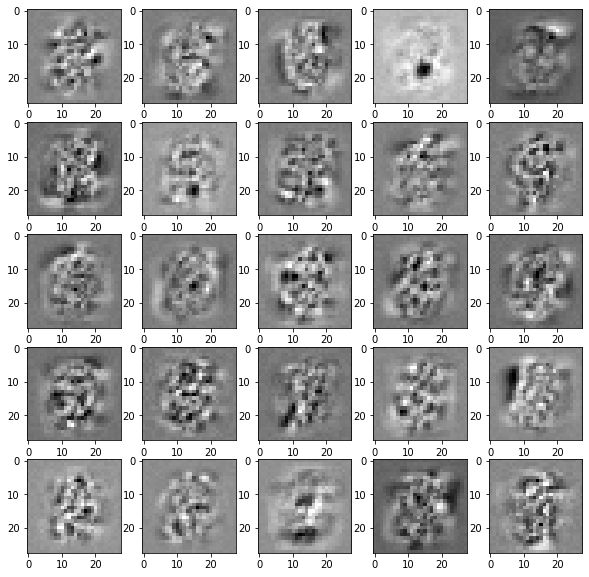

In [45]:
learned_weights = rbm_mnist.W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

In [46]:
#This is an unsupervised learning algorithm. So let us try training on one particular number.But first
# we need to seperate the data.

number = 5 #A number between 0 and 10.

particular_mnist = []

limit = mnist_data.train_data.shape[0]
# limit = 60000
for i in range(limit):
    if(mnist_data.train_labels[i] == number):
        particular_mnist.append(mnist_data.train_data[i].numpy())
# particular_mnist = np.array(particular_mnist)
len(particular_mnist)
# mnist_data.train_data

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


5421

In [47]:
tensor_x = torch.stack([torch.Tensor(i) for i in particular_mnist]).type(torch.FloatTensor)
tensor_y = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))]).type(torch.FloatTensor)

In [48]:
mnist_particular_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
mnist_particular_dataloader = torch.utils.data.DataLoader(mnist_particular_dataset,batch_size = batch_size,drop_last=True,num_workers=0)

In [49]:
visible_units=28*28
hidden_units = 500
k=3
learning_rate=0.01
learning_rate_decay = False
xavier_init = True
increase_to_cd_k = False
use_gpu = False


rbm_mnist = RBM(visible_units,hidden_units,k ,learning_rate,learning_rate_decay,xavier_init,
                increase_to_cd_k,use_gpu)


epochs = 10

rbm_mnist.train(mnist_particular_dataloader , epochs)


RBM fitting: 0it [00:00, ?it/s]
RBM fitting: 17it [00:00, 160.82it/s]
RBM fitting: 34it [00:00, 162.80it/s]
RBM fitting: 51it [00:00, 164.08it/s]
RBM fitting: 68it [00:00, 164.69it/s]
RBM fitting: 85it [00:00, 165.55it/s]
RBM fitting: 103it [00:00, 167.53it/s]
RBM fitting: 120it [00:00, 166.03it/s]
RBM fitting: 137it [00:00, 166.61it/s]
RBM fitting: 154it [00:00, 166.81it/s]
RBM fitting: 171it [00:01, 166.57it/s]
RBM fitting: 189it [00:01, 168.41it/s]
RBM fitting: 207it [00:01, 169.84it/s]
RBM fitting: 225it [00:01, 170.63it/s]
RBM fitting: 243it [00:01, 171.27it/s]
RBM fitting: 261it [00:01, 169.90it/s]
RBM fitting: 278it [00:01, 168.78it/s]
RBM fitting: 295it [00:01, 164.32it/s]
RBM fitting: 312it [00:01, 165.32it/s]
RBM fitting: 329it [00:01, 166.15it/s]
RBM fitting: 346it [00:02, 167.19it/s]
RBM fitting: 363it [00:02, 165.90it/s]
RBM fitting: 380it [00:02, 166.85it/s]
RBM fitting: 398it [00:02, 168.75it/s]
RBM fitting: 416it [00:02, 169.65it/s]
RBM fitting: 433it [00:02, 167.58it/

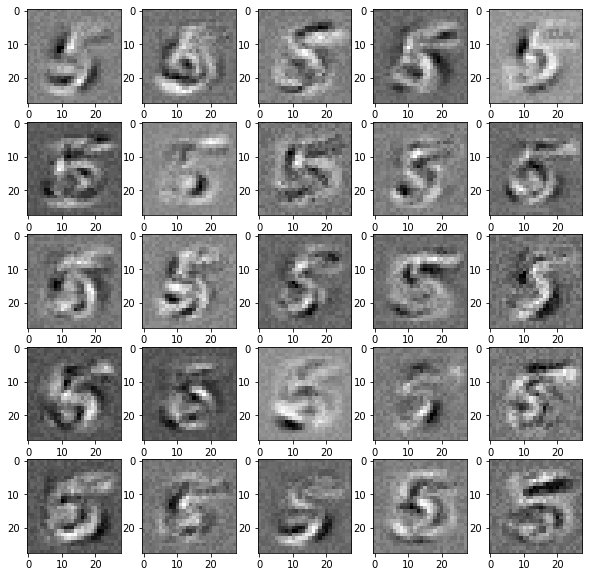

In [50]:
# This shows the weights for each of the 64 hidden neurons and give an idea how each neuron is activated.

learned_weights = rbm_mnist.W.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i, :].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

The original number: 3


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


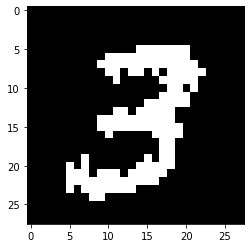

The reconstructed image


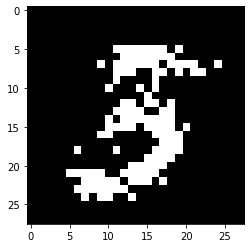

In [51]:
#Lets try reconstructing a random number from this model which has learned 5
idx = 7
img = mnist_data.train_data[idx]
reconstructed_img = img.view(-1).type(torch.FloatTensor)

# _ , reconstructed_img = rbm_mnist.to_hidden(reconstructed_img)
# _ , reconstructed_img = rbm_mnist.to_visible(reconstructed_img)

_,reconstructed_img = rbm_mnist.reconstruct(reconstructed_img,1)
# print(reconstructed_img)
reconstructed_img = reconstructed_img.view((28,28))
print("The original number: {}".format(mnist_data.train_labels[idx]))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()